# Generate the training set with L and PBand

Generation of the training set for the machine learning algorithm, composed by L and PBand

_time < 5m_

_Input: AGB vector from N1, LBand and PBand from N2_

## 1. Import modules

In [1]:
import plant
import pickle
import math
from os import path
from multiprocessing import Process, Manager
import numpy as np

## 2. Global variables

In [2]:
from config import *

In [3]:
subplot_width_m = 40
subplot_width = subplot_width_m // 20
n_subplots = (5-(subplot_width-1))**2
n_plots = 12

agb_vect = pickle.load(open(file_agb_vector, 'rb'))

## 3. Colocate all the polarization of the LBand, and the PBand with the field data

In [4]:
manager = Manager()
mean_LHH_shared = manager.dict()
mean_LHV_shared = manager.dict()
mean_LVV_shared = manager.dict()
mean_PHV_shared = manager.dict()

def create_vect_shared(plot_start, plot_end):
    for subplot in range(1, n_subplots + 1):
        for plot in range(plot_start, plot_end):
            if plant.isnan(agb_vect[subplot - 1, plot - 1]):
                print(f'sublot {subplot} field plot {plot} is NaN')
                continue
            print(f'processing subplot {subplot} field plot {plot}...')
            plot_number = f'{(plot):02}'
            est_tree_height_file = path.join(field_output_dir,
                                             f'plot_{plot_number}/plot_{plot_number}_s{subplot}_tree_height_field_estimated.bin')
            est_tree_height_radar_file_LHH = path.join(uavsar_output_dir,
                                                       f'plot_{plot_number}/plot_{plot_number}_s{subplot}_tree_height_field_radar_LHH.{output_ext}')
            est_tree_height_radar_file_LHV = path.join(uavsar_output_dir,
                                                       f'plot_{plot_number}/plot_{plot_number}_s{subplot}_tree_height_field_radar_LHV.{output_ext}')
            est_tree_height_radar_file_LVV = path.join(uavsar_output_dir,
                                                       f'plot_{plot_number}/plot_{plot_number}_s{subplot}_tree_height_field_radar_LVV.{output_ext}')
            est_tree_height_radar_file_PHV = path.join(pband_output_dir,
                                                       f'plot_{plot_number}/plot_{plot_number}_s{subplot}_tree_height_field_radar_PHV.{output_ext}')
            plant.mosaic(file_LHH,
                         bbox_file=est_tree_height_file,
                         output_file=est_tree_height_radar_file_LHH,
                         interp='average',
                         **options)
            plant.mosaic(file_LHV,
                         bbox_file=est_tree_height_file,
                         output_file=est_tree_height_radar_file_LHV,
                         interp='average',
                         **options)
            plant.mosaic(file_LVV,
                         bbox_file=est_tree_height_file,
                         output_file=est_tree_height_radar_file_LVV,
                         interp='average',
                         **options)
            plant.mosaic(file_PHV,
                         bbox_file=est_tree_height_file,
                         output_file=est_tree_height_radar_file_PHV,
                         interp='average',
                         **options)

            mean_LHH_shared[subplot - 1, plot - 1] = plant.plant_info(est_tree_height_radar_file_LHH,
                                                                    data_mean=True,
                                                                    **options).image[0][0]
            mean_LHV_shared[subplot - 1, plot - 1] = plant.plant_info(est_tree_height_radar_file_LHV,
                                                                    data_mean=True,
                                                                    **options).image[0][0]
            mean_LVV_shared[subplot - 1, plot - 1] = plant.plant_info(est_tree_height_radar_file_LVV,
                                                                    data_mean=True,
                                                                    **options).image[0][0]
            mean_PHV_shared[subplot - 1, plot - 1] = plant.plant_info(est_tree_height_radar_file_PHV,
                                                                    data_mean=True,
                                                                    **options).image[0][0]
base_plots_pp = math.floor(n_plots / N_PROCESSES)
remainder_pp = n_plots % N_PROCESSES
offset_pp = 0
processes = list()
for i in range(N_PROCESSES):
    start_pl = (i*base_plots_pp) + offset_pp + 1
    end_pl = start_pl + base_plots_pp + (1 if remainder_pp > 0 else 0)
    if remainder_pp > 0:
        remainder_pp -= 1
        offset_pp += 1
    p = Process(target=create_vect_shared, args=(start_pl, end_pl))
    p.start()
    processes.append(p)
for p in processes:
        p.join()

mean_LHV_dict = dict(mean_LHV_shared)
mean_LHH_dict = dict(mean_LHH_shared)
mean_LVV_dict = dict(mean_LVV_shared)
mean_PHV_dict = dict(mean_PHV_shared)
mean_LHH_vect = np.full((n_subplots, n_plots), np.nan)
mean_LHV_vect = np.full((n_subplots, n_plots), np.nan)
mean_LVV_vect = np.full((n_subplots, n_plots), np.nan)
mean_PHV_vect = np.full((n_subplots, n_plots), np.nan)
for item in mean_LHV_dict.items():
    mean_LHV_vect[item[0]] = item[1]
for item in mean_LHH_dict.items():
    mean_LHH_vect[item[0]] = item[1]
for item in mean_LVV_dict.items():
    mean_LVV_vect[item[0]] = item[1]
for item in mean_PHV_dict.items():
    mean_PHV_vect[item[0]] = item[1]

LHH_vect_file = path.join(uavsar_output_dir, 'n4', f'LHH_vect.{output_ext}')
LHV_vect_file = path.join(uavsar_output_dir, 'n4', f'LHV_vect.{output_ext}')
LVV_vect_file = path.join(uavsar_output_dir, 'n4', f'LVV_vect.{output_ext}')
PHV_vect_file = path.join(pband_output_dir, 'n4', f'PHV_vect.{output_ext}')

plant.util(mean_LHH_vect, output_file=LHH_vect_file, **options)
plant.util(mean_LHV_vect, output_file=LHV_vect_file, **options)
plant.util(mean_LVV_vect, output_file=LVV_vect_file, **options)
plant.util(mean_PHV_vect, output_file=PHV_vect_file, **options)

processing subplot 1 field plot 1...
processing subplot 1 field plot 3...
processing subplot 1 field plot 5...
processing subplot 1 field plot 7...
processing subplot 1 field plot 9...
processing subplot 1 field plot 10...
processing subplot 1 field plot 12...
processing subplot 1 field plot 11...
processing subplot 2 field plot 9...
processing subplot 2 field plot 11...
processing subplot 1 field plot 8...
processing subplot 2 field plot 12...
processing subplot 2 field plot 10...
processing subplot 1 field plot 4...
processing subplot 1 field plot 6...
processing subplot 1 field plot 2...
processing subplot 3 field plot 11...
processing subplot 3 field plot 9...
processing subplot 2 field plot 5...
processing subplot 2 field plot 7...
processing subplot 2 field plot 3...
processing subplot 3 field plot 12...
processing subplot 2 field plot 1...
processing subplot 3 field plot 10...
processing subplot 4 field plot 11...
processing subplot 4 field plot 9...
processing subplot 4 field p

PlantImage('MEM:140647017541192')

## 4. Visualize the histogram of the data

PLAnT 0.1.03dev (API) - plant_display.py "/projects/D3/dat/lband/rtc/output/n4/LHV_vect.tiff" --db --label "LHV" "/projects/D3/dat/pband/output/n4/PHV_vect.tiff" --db --label "PHV" --title "L and PBand training sets" --label-x "Backscatter [dB]" --no-grid --hist --nbins "20" --mute


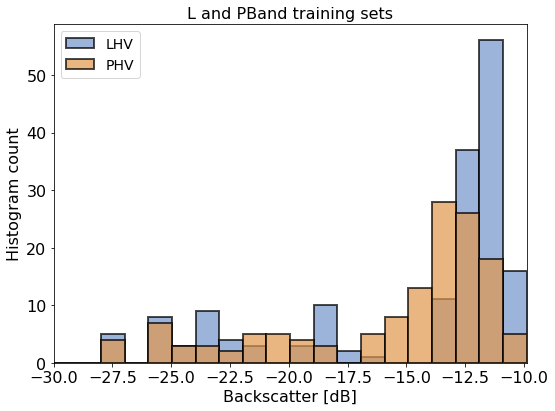

In [7]:
display_options_fit_str = ('--no-grid --hist --nbins 20 --mute')
_ = plant.execute(f'plant_display.py {LHV_vect_file} --db --label "LHV" {PHV_vect_file} --db --label "PHV" --title "L and PBand training sets" --label-x "Backscatter [dB]" {display_options_fit_str}')

PLAnT 0.1.03dev (API) - plant_display.py "/projects/D3/dat/field/output/agb_vect.tiff" --title "Field data ground truth" --label-x "Biomass [Mg/ha]" --no-grid --hist --nbins "20" --mute


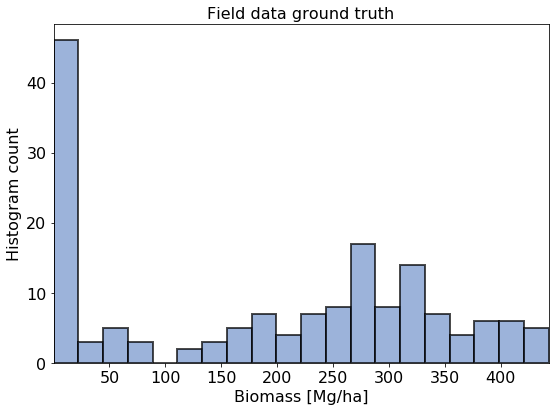

In [6]:
_ = plant.execute(f'plant_display.py {agb_vect_file} --title "Field data ground truth" --label-x "Biomass [Mg/ha]" {display_options_fit_str}')

Share the results with the MAAP: LBand and PBand vectors